In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.laplace import Laplace
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import  tqdm
import seaborn as sns; sns.set()
import pickle as pkl
from pathlib import Path
import pandas as pd
from functools import partial 

sns.set(rc={'figure.figsize':(15, 6)})

In [2]:
DEVICE = torch.device("cuda:3")
DATA_ROOT = Path('../data')

In [3]:
torch.cuda.is_available()

True

# Data & Model Prep

## Data

In [4]:
def make_data(transforms):

    trainset = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=True,
                                            download=True, transform=transforms)

    testset = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=False,
                                           download=True, transform=transforms)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader


CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Models

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


convnet = ConvNet()
convnet.to(DEVICE)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Thresholdout

In [6]:
class Thresholdout:
    def __init__(self, train, holdout, tolerance=0.01/4, scale_factor=4, keep_log=True):
        self.tolerance = tolerance
        
        self.laplace_eps = Laplace(torch.tensor([0.0]), torch.tensor([2*self.tolerance]))
        self.laplace_gamma = Laplace(torch.tensor([0.0]), torch.tensor([4*self.tolerance]))
        self.laplace_eta = Laplace(torch.tensor([0.0]), torch.tensor([8*self.tolerance]))

        self.train = train
        self.holdout = holdout
        
        self.T = 4*tolerance + self.noise(self.laplace_gamma)
        # self.budget = ???
        
        self.keep_log = keep_log
        if keep_log:
            self.log = pd.DataFrame(columns=['GlobStep', 'threshold', 'delta', 'phi_train', 'phi_holdout', 'estimate', 'overfit'])
        
        
    def noise(self, dist):
        return dist.sample().item()
        
    def verify_statistic(self, phi, glob_step=None):
        """
            - phi(dataset) -> statistic: 
              function returns the average of some statistic
        """
        
        train_val = phi(self.train)
        holdout_val = phi(self.holdout)
                
        delta = abs(train_val - holdout_val)
        thresh = self.T + self.noise(self.laplace_eta)
        
        if delta > thresh:
            self.T += self.noise(self.laplace_gamma)
            estimate = holdout_val + self.noise(self.laplace_eps)
        else:
            estimate = train_val
            
        if self.keep_log:
            if glob_step is None: 
                raise ValueException('please provide glob step if logging is on')
            self.log.loc[len(self.log)] = [glob_step, thresh, delta, train_val, holdout_val, estimate, delta > thresh]
            
        return estimate
            
        

In [7]:
def test_accuracy(model, data_loader): 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(DEVICE), data[1]
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

# Training

In [8]:
def train(model, data, epochs=20, sample_step=1000):
    
    trainloader, testloader = data
    tout = Thresholdout(trainloader, testloader, keep_log=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    
    loss_history = []
    glob_step = 0
    
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_history += [loss.item()]
            glob_step += 1
            
            if i % sample_step == 0 and i:
                acc_val = tout.verify_statistic(partial(test_accuracy, model), glob_step)
                print(f'[{epoch+1}, step::{i}] loss [{running_loss / sample_step :.3f}] accuracy [{acc_val:.3f}]')
                running_loss = 0.0
                
    return loss_history, tout
    
    
    
    

In [9]:
conv_transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
conv_data = make_data(conv_transform)
conv_history, convtout = train(convnet, conv_data)

Files already downloaded and verified
Files already downloaded and verified


[1, step::1000] loss [1.878] accuracy [0.383]
[1, step::2000] loss [1.613] accuracy [0.434]
[1, step::3000] loss [1.531] accuracy [0.464]
[2, step::1000] loss [1.442] accuracy [0.482]
[2, step::2000] loss [1.413] accuracy [0.489]
[2, step::3000] loss [1.374] accuracy [0.510]
[3, step::1000] loss [1.305] accuracy [0.528]
[3, step::2000] loss [1.291] accuracy [0.550]
[3, step::3000] loss [1.275] accuracy [0.541]
[4, step::1000] loss [1.220] accuracy [0.538]
[4, step::2000] loss [1.200] accuracy [0.577]
[4, step::3000] loss [1.201] accuracy [0.558]
[5, step::1000] loss [1.161] accuracy [0.580]
[5, step::2000] loss [1.150] accuracy [0.580]
[5, step::3000] loss [1.119] accuracy [0.594]
[6, step::1000] loss [1.101] accuracy [0.572]
[6, step::2000] loss [1.083] accuracy [0.591]
[6, step::3000] loss [1.083] accuracy [0.589]
[7, step::1000] loss [1.039] accuracy [0.603]
[7, step::2000] loss [1.054] accuracy [0.584]
[7, step::3000] loss [1.038] accuracy [0.621]
[8, step::1000] loss [1.011] accur

In [12]:
len(df)

60

In [14]:
with open('convnet-outcome.pkl','wb') as fp:
    pkl.dump((conv_history, convtout), fp)

In [10]:
df = convtout.log

In [13]:
df

,GlobStep,threshold,delta,phi_train,phi_holdout,estimate,overfit
0,1001,0.023347,0.00004,0.38264,0.3826,0.382640,False
1,2001,-0.021424,0.00400,0.43760,0.4336,0.433547,True
2,3001,-0.011971,0.00110,0.46220,0.4611,0.464234,True
3,4126,-0.026733,0.00036,0.48314,0.4835,0.481943,True
4,5126,-0.008287,0.00862,0.50972,0.5011,0.488755,True
5,6126,-0.017283,0.01208,0.51908,0.5070,0.509735,True
6,7251,-0.100606,0.00832,0.53922,0.5309,0.528483,True
7,8251,-0.034976,0.01736,0.55686,0.5395,0.550288,True
8,9251,-0.106600,0.01894,0.55994,0.5410,0.541197,True
9,10376,0.008021,0.02036,0.56206,0.5417,0.537625,True


In [19]:
df['overfit'] = df['delta'] > df['threshold']

In [20]:
df

,GlobStep,threshold,delta,phi_train,phi_holdout,overfit
0,1001.0,0.006043,0.00004,0.37394,0.3739,False
1,2001.0,0.012523,0.00182,0.43462,0.4328,False
2,3001.0,0.065114,0.00594,0.45314,0.4472,False
3,4126.0,0.007891,0.00720,0.49090,0.4837,False
4,5126.0,0.059908,0.00678,0.51068,0.5039,False
5,6126.0,0.046002,0.00408,0.52908,0.5250,False
6,7251.0,0.014633,0.00792,0.54372,0.5358,False
7,8251.0,-0.014221,0.01090,0.54690,0.5360,True
8,9251.0,-0.005837,0.01360,0.55890,0.5453,True
9,10376.0,-0.002225,0.01480,0.57200,0.5572,True


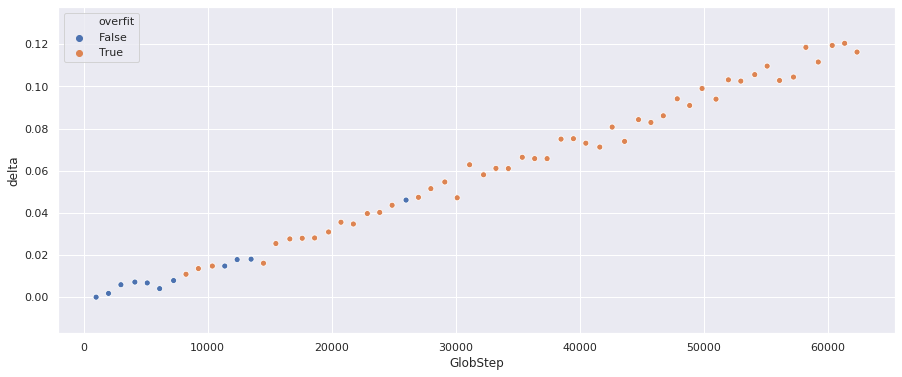

In [27]:
sns.scatterplot(data=df, x="GlobStep", y="delta", hue='overfit')